In [25]:
from dipy.viz import window, actor
from dipy.io.streamline import load_trk, save_trk
from bundlewarp import bundlewarp, bundlewarp_vector_filed, bundlewarp_shape_analysis
from dipy.tracking.streamline import set_number_of_points, unlist_streamlines, Streamlines
from dipy.data import two_cingulum_bundles 
import numpy as np
from time import time

In [2]:
def viz_bundles(b1, b2, c1=(1,0,0), c2=(0,1,0)):
    
    ren = window.Scene()
    ren.SetBackground(1, 1, 1)

    actor1 = actor.line(b1, colors=c1)
    actor1.GetProperty().SetEdgeVisibility(1)
    actor1.GetProperty().SetRenderLinesAsTubes(1)
    actor1.GetProperty().SetLineWidth(6)
    actor1.GetProperty().SetOpacity(1)

    ren.add(actor1)


    actor2 = actor.line(b2, colors=c2)
    actor2.GetProperty().SetEdgeVisibility(1)
    actor2.GetProperty().SetRenderLinesAsTubes(1)
    actor2.GetProperty().SetLineWidth(6)
    actor2.GetProperty().SetOpacity(1)

    ren.add(actor2)
    window.show(ren)

In [3]:
def viz_bundle(b1, c1=None):
    
    ren = window.Scene()
    ren.SetBackground(1, 1, 1)

    actor1 = actor.line(b1, colors=c1)
    actor1.GetProperty().SetEdgeVisibility(1)
    actor1.GetProperty().SetRenderLinesAsTubes(1)
    actor1.GetProperty().SetLineWidth(6)
    actor1.GetProperty().SetOpacity(1)

    ren.add(actor1)

    window.show(ren)

In [4]:
#cb_subj1, cb_subj2 = two_cingulum_bundles()

cb_subj1 = load_trk("data/s_UF_L.trk", reference="same", bbox_valid_check=False).streamlines
cb_subj2 = load_trk("data/m_UF_L.trk", reference="same", bbox_valid_check=False).streamlines

static = Streamlines(set_number_of_points(cb_subj1, 20)) #fixed or reference
moving = Streamlines(set_number_of_points(cb_subj2, 20)) # to be registered to static


<font size=4 color='darkgreen'>Visualize static bundle in red and moving in green before registration</font>

In [5]:
viz_bundles(static, moving)

# Let's partially deform bundle by setting $\lambda=0.3$

In [6]:
start = time()
moving_aligned, deformed_bundle, distances, match_pairs, warp_map = bundlewarp(static, moving, alpha=0.3, beta=20, max_iter=15)
end = time()

print("time taken by BundleWarp registration in seconds = ", end-start)

time taken by BundleWarp registration in seconds =  3.4488372802734375


--------------------------------------------------
<font size=4 color='darkgreen'>Visualized static and moved bundle to alignment</font>

In [7]:
viz_bundles(static, deformed_bundle)

<font size=4 color='darkgreen'>Visualize linearly moved in blue and  nonlinearly moved in green to see BundleWarp registartion improvement over linear registration</font>

In [8]:
viz_bundles(moving_aligned, deformed_bundle, c1=(0,0,1))

<font size=4 color='darkgreen'>Now, let's visualize deformation vector field generated by BundleWarp

<font size=4 color='darkgreen'>This shows us where and how much and in what directions deformations were added by BundleWarp</font>

In [9]:
offsets, directions, colors = bundlewarp_vector_filed(moving_aligned, deformed_bundle)

In [10]:
points_aligned, _ = unlist_streamlines(moving_aligned)

<font size=4 color='darkgreen'>Visualize just the vector field

In [11]:
scene = window.Scene()
scene.SetBackground(1., 1, 1)
arrows = actor.arrow(points_aligned, directions, colors, offsets)
scene.add(arrows)
window.show(scene)

<font size=4 color='darkgreen'>Visualize vector field over linearly moved bundle

In [12]:
scene = window.Scene()
scene.SetBackground(1., 1, 1)
actor1 = actor.line(moving_aligned, colors=(0,0,1))
arrows = actor.arrow(points_aligned, directions, colors, offsets)
scene.add(arrows)
scene.add(actor1)
window.show(scene)

<font size=4 color='darkgreen'>Visualize magnitude of deformations over linearly moved bundle

<font size=4 color='darkgreen'>It shows which streamlines were deformed the most 

In [14]:
scene = window.Scene()
hue = (0.1, 0.9)  # blue only
hue = (0.9, 0.3)
saturation = (0.5, 1)  # black to white
scene.background((1,1,1))
lut_cmap = actor.colormap_lookup_table(
    scale_range=(offsets.min(), offsets.max()),
    hue_range=hue,
    saturation_range=saturation)

stream_actor = actor.line(moving_aligned, offsets, linewidth=7,
                           lookup_colormap=lut_cmap)


scene.add(stream_actor)
bar = actor.scalar_bar(lut_cmap)

scene.add(bar)
window.show(scene)

<font size=4 color='darkgreen'>We can also directly visualize magnitude of deformations over nonlinearly moved bundle (deformed bundle)



In [16]:
scene = window.Scene()
hue = (0.1, 0.9)  # blue only
hue = (0.9, 0.3)
saturation = (0.5, 1)  # black to white
scene.background((1,1,1))
lut_cmap = actor.colormap_lookup_table(
    scale_range=(offsets.min(), offsets.max()),
    hue_range=hue,
    saturation_range=saturation)

stream_actor = actor.line(deformed_bundle, offsets, linewidth=7,
                           lookup_colormap=lut_cmap)


scene.add(stream_actor)
bar = actor.scalar_bar(lut_cmap)

scene.add(bar)
window.show(scene)

# Let's fully deform bundle by setting $\lambda<0.01$

<font size=4 color='blue'>We use MDF distances computed and returned by previous run of BundleWarp method. This will save computation.

In [17]:
start = time()
moving_aligned, deformed_bundle2, distances, match_pairs, warp_map = bundlewarp(static, moving, dist=distances, alpha=0.001, beta=20, precomputed=True)
end = time()

print("time taken by BundleWarp registration in seconds = ", end-start)

using pre-computed distances
time taken by BundleWarp registration in seconds =  1.7164762020111084


--------------------------------------------------
<font size=4 color='darkgreen'>Visualized static and moved bundle to alignment

In [18]:
viz_bundles(static, deformed_bundle2)

<font size=4 color='darkgreen'>Now, let's visualize deformation vector field generated by BundleWarp

<font size=4 color='darkgreen'>This shows us where and how much and in what directions deformations were added by BundleWarp

In [19]:
points_aligned, _ = unlist_streamlines(moving_aligned)
offsets2, directions2, colors2 = bundlewarp_vector_filed(moving_aligned, deformed_bundle2)

<font size=4 color='darkgreen'>Visualize just the vector field

In [20]:
scene = window.Scene()
scene.SetBackground(1., 1, 1)
arrows = actor.arrow(points_aligned, directions2, colors2, offsets2)
scene.add(arrows)
window.show(scene)

<font size=4 color='darkgreen'>Visualize vector field over linearly moved bundle

In [21]:
scene = window.Scene()
scene.SetBackground(1., 1, 1)
actor1 = actor.line(moving_aligned, colors=(0,0,1))
arrows = actor.arrow(points_aligned, directions2, colors2, offsets2)
scene.add(arrows)
scene.add(actor1)
window.show(scene)

<font size=4 color='darkgreen'>Visualize magnitude of deformations over linearly moved bundle

<font size=4 color='darkgreen'>It shows which streamlines were deformed the most 

In [22]:
scene = window.Scene()
hue = (0.1, 0.9)  # blue only
hue = (0.9, 0.3)
saturation = (0.5, 1)  # black to white
scene.background((1,1,1))
lut_cmap = actor.colormap_lookup_table(
    scale_range=(offsets2.min(), offsets2.max()),
    hue_range=hue,
    saturation_range=saturation)

stream_actor = actor.line(moving_aligned, offsets2, linewidth=7,
                           lookup_colormap=lut_cmap)


scene.add(stream_actor)
bar = actor.scalar_bar(lut_cmap)

scene.add(bar)
window.show(scene)

<font size=4 color='darkgreen'>We can also directly visualize magnitude of deformations over nonlinearly moved bundle (deformed bundle)


In [23]:
scene = window.Scene()
hue = (0.1, 0.9)  # blue only
hue = (0.9, 0.3)
saturation = (0.5, 1)  # black to white
scene.background((1,1,1))
lut_cmap = actor.colormap_lookup_table(
    scale_range=(offsets2.min(), offsets2.max()),
    hue_range=hue,
    saturation_range=saturation)

stream_actor = actor.line(deformed_bundle2, offsets2, linewidth=7,
                           lookup_colormap=lut_cmap)


scene.add(stream_actor)
bar = actor.scalar_bar(lut_cmap)

scene.add(bar)
window.show(scene)

# Bundle Shape Difference Analysis with BundleWarp

<font size=4 color='blue'>Using vector field generated by fully deforming bundle we can do bundle shape difference analysis

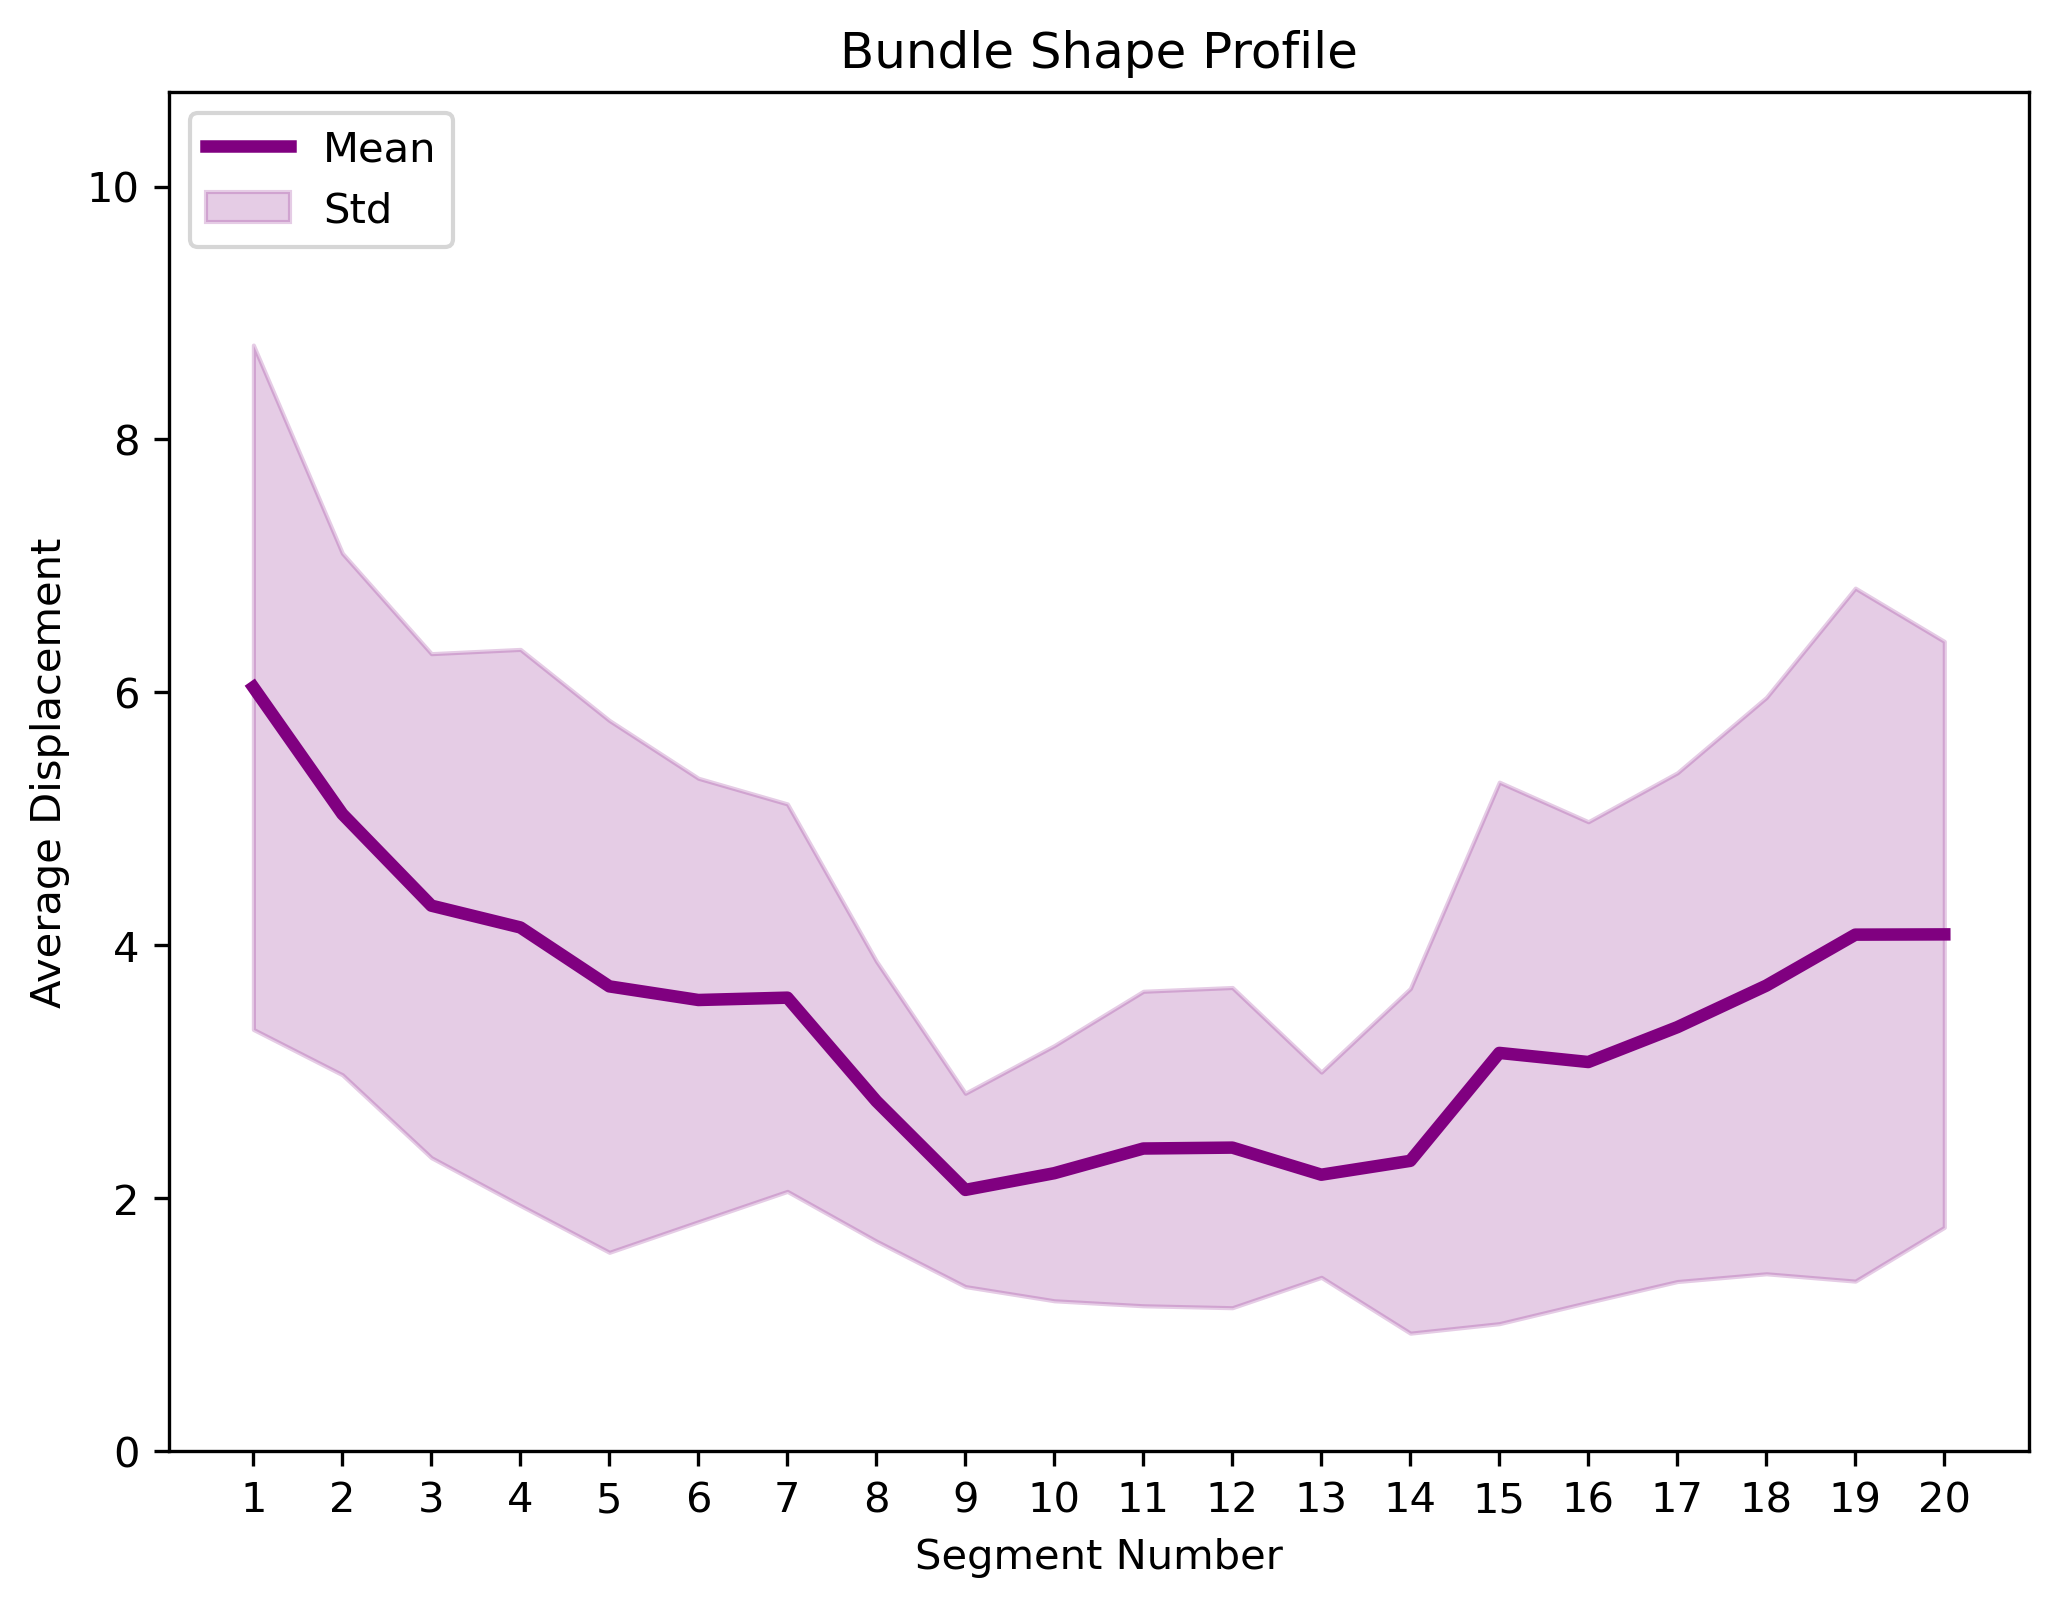

In [28]:
bundlewarp_shape_analysis(moving_aligned, deformed_bundle2, no_disks=20)

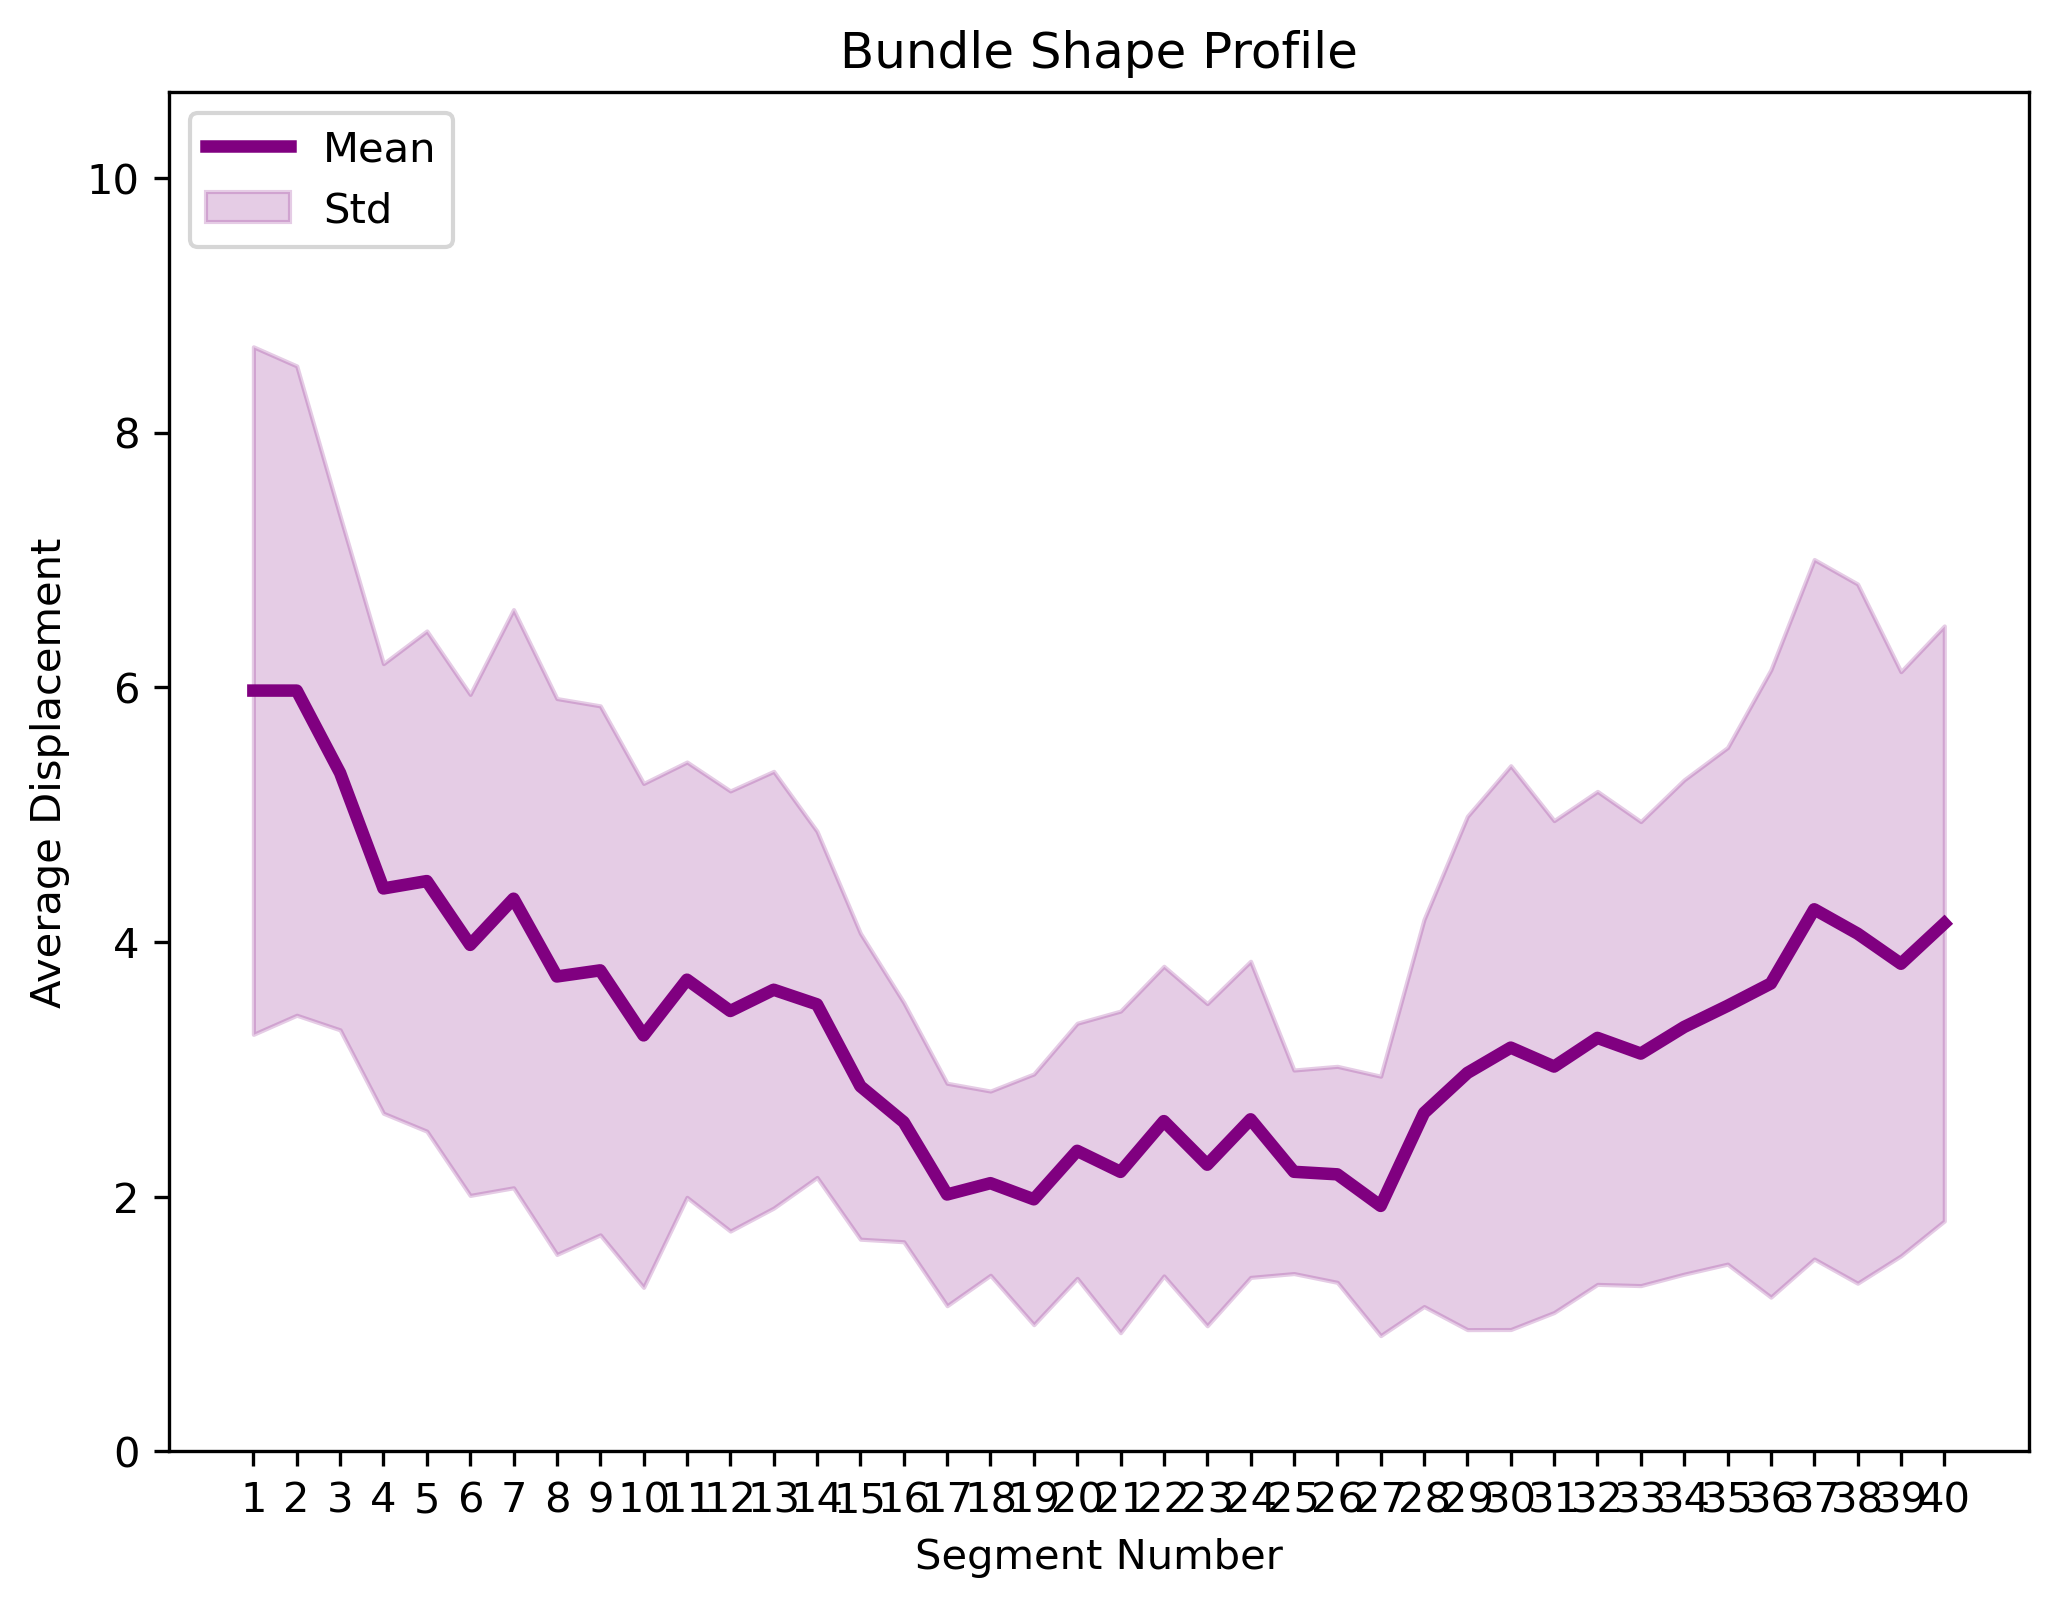

In [27]:
bundlewarp_shape_analysis(moving_aligned, deformed_bundle2, no_disks=40)